#CS 7641 ML Project

This notebook is for dataset preprocessing

## Load google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Install required libraries

In [2]:
!pip3 install scanpy anndata leidenalg louvain igraph

## Import required libraries

In [3]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy

## Load dataset

In [4]:
file_path = '/content/drive/MyDrive/Colab_Notebooks/CS7641_ML/data/dataset.csv'
# file_path = '/content/drive/MyDrive/CS7641_ML/data/dataset.csv'

df = pd.read_csv(file_path)

df.set_index('patient_id', inplace=True)

print(f'Dataframe check: {df.shape}, {df.index.name}, {df.columns.tolist()}')

df.head()

Dataframe check: (1904, 692), patient_id, ['age_at_diagnosis', 'type_of_breast_surgery', 'cancer_type', 'cancer_type_detailed', 'cellularity', 'chemotherapy', 'pam50_+_claudin-low_subtype', 'cohort', 'er_status_measured_by_ihc', 'er_status', 'neoplasm_histologic_grade', 'her2_status_measured_by_snp6', 'her2_status', 'tumor_other_histologic_subtype', 'hormone_therapy', 'inferred_menopausal_state', 'integrative_cluster', 'primary_tumor_laterality', 'lymph_nodes_examined_positive', 'mutation_count', 'nottingham_prognostic_index', 'oncotree_code', 'overall_survival_months', 'overall_survival', 'pr_status', 'radio_therapy', '3-gene_classifier_subtype', 'tumor_size', 'tumor_stage', 'death_from_cancer', 'brca1', 'brca2', 'palb2', 'pten', 'tp53', 'atm', 'cdh1', 'chek2', 'nbn', 'nf1', 'stk11', 'bard1', 'mlh1', 'msh2', 'msh6', 'pms2', 'epcam', 'rad51c', 'rad51d', 'rad50', 'rb1', 'rbl1', 'rbl2', 'ccna1', 'ccnb1', 'cdk1', 'ccne1', 'cdk2', 'cdc25a', 'ccnd1', 'cdk4', 'cdk6', 'ccnd2', 'cdkn2a', 'cdkn

/tmp/ipython-input-4-3516925546.py:4: DtypeWarning: Columns (678,688,690,692) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


,age_at_diagnosis,type_of_breast_surgery,cancer_type,cancer_type_detailed,cellularity,chemotherapy,pam50_+_claudin-low_subtype,cohort,er_status_measured_by_ihc,er_status,...,mtap_mut,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,hras_mut,prps2_mut,smarcb1_mut,stmn2_mut,siah1_mut
patient_id,,,,,,,,,,,,,,,,,,,,,
0,75.65,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,0,claudin-low,1.0,Positve,Positive,...,0,0,0,0,0,0,0,0,0,0
2,43.19,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,High,0,LumA,1.0,Positve,Positive,...,0,0,0,0,0,0,0,0,0,0
5,48.87,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,1,LumB,1.0,Positve,Positive,...,0,0,0,0,0,0,0,0,0,0
6,47.68,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,1,LumB,1.0,Positve,Positive,...,0,0,0,0,0,0,0,0,0,0
8,76.97,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,1,LumB,1.0,Positve,Positive,...,0,0,0,0,0,0,0,0,0,0


In [5]:
target_column = 'pam50_+_claudin-low_subtype'
target_pd_series = df[target_column]
print(f'Target column unique values and counts: {df[target_column].value_counts()}')

target_pd_series.head()

Target column unique values and counts: pam50_+_claudin-low_subtype
LumA           679
LumB           461
Her2           220
claudin-low    199
Basal          199
Normal         140
NC               6
Name: count, dtype: int64


,pam50_+_claudin-low_subtype
patient_id,
0,claudin-low
2,LumA
5,LumB
6,LumB
8,LumB


In [6]:
df = df.drop(columns=[target_column])

## Break dataframe into clinical dataframe and genes dataframe and basic checks

In [7]:
# Separate clinical data for gene
clinical_columns = df.columns.tolist()[0:29]
genes_columns = df.columns.tolist()[29:29+489]
mutation_genes_columns = df.columns.tolist()[29+489:]

print(f'Clinical columns: {len(clinical_columns)} {clinical_columns}')
print(f'Genes columns: {len(genes_columns)} {genes_columns}')
print(f'Mutation genes columns: {len(mutation_genes_columns)} {mutation_genes_columns}')

Clinical columns: 29 ['age_at_diagnosis', 'type_of_breast_surgery', 'cancer_type', 'cancer_type_detailed', 'cellularity', 'chemotherapy', 'cohort', 'er_status_measured_by_ihc', 'er_status', 'neoplasm_histologic_grade', 'her2_status_measured_by_snp6', 'her2_status', 'tumor_other_histologic_subtype', 'hormone_therapy', 'inferred_menopausal_state', 'integrative_cluster', 'primary_tumor_laterality', 'lymph_nodes_examined_positive', 'mutation_count', 'nottingham_prognostic_index', 'oncotree_code', 'overall_survival_months', 'overall_survival', 'pr_status', 'radio_therapy', '3-gene_classifier_subtype', 'tumor_size', 'tumor_stage', 'death_from_cancer']
Genes columns: 489 ['brca1', 'brca2', 'palb2', 'pten', 'tp53', 'atm', 'cdh1', 'chek2', 'nbn', 'nf1', 'stk11', 'bard1', 'mlh1', 'msh2', 'msh6', 'pms2', 'epcam', 'rad51c', 'rad51d', 'rad50', 'rb1', 'rbl1', 'rbl2', 'ccna1', 'ccnb1', 'cdk1', 'ccne1', 'cdk2', 'cdc25a', 'ccnd1', 'cdk4', 'cdk6', 'ccnd2', 'cdkn2a', 'cdkn2b', 'myc', 'cdkn1a', 'cdkn1b', 

In [8]:
# Create clinical and gene dataframes
clinical_df = df[clinical_columns]
genes_df = df[genes_columns]
mutation_genes_df = df[mutation_genes_columns]

print(f'Clinical dataframe: {clinical_df.shape}, {clinical_df.index.name}, {clinical_df.columns.tolist()}')
print(f'Genes dataframe: {genes_df.shape}, {genes_df.index.name}, {genes_df.columns.tolist()}')
print(f'Mutation genes dataframe: {mutation_genes_df.shape}, {mutation_genes_df.index.name}, {mutation_genes_df.columns.tolist()}')

Clinical dataframe: (1904, 29), patient_id, ['age_at_diagnosis', 'type_of_breast_surgery', 'cancer_type', 'cancer_type_detailed', 'cellularity', 'chemotherapy', 'cohort', 'er_status_measured_by_ihc', 'er_status', 'neoplasm_histologic_grade', 'her2_status_measured_by_snp6', 'her2_status', 'tumor_other_histologic_subtype', 'hormone_therapy', 'inferred_menopausal_state', 'integrative_cluster', 'primary_tumor_laterality', 'lymph_nodes_examined_positive', 'mutation_count', 'nottingham_prognostic_index', 'oncotree_code', 'overall_survival_months', 'overall_survival', 'pr_status', 'radio_therapy', '3-gene_classifier_subtype', 'tumor_size', 'tumor_stage', 'death_from_cancer']
Genes dataframe: (1904, 489), patient_id, ['brca1', 'brca2', 'palb2', 'pten', 'tp53', 'atm', 'cdh1', 'chek2', 'nbn', 'nf1', 'stk11', 'bard1', 'mlh1', 'msh2', 'msh6', 'pms2', 'epcam', 'rad51c', 'rad51d', 'rad50', 'rb1', 'rbl1', 'rbl2', 'ccna1', 'ccnb1', 'cdk1', 'ccne1', 'cdk2', 'cdc25a', 'ccnd1', 'cdk4', 'cdk6', 'ccnd2', '

In [9]:
# Understand our clinical dataset
clinical_df.describe(include='all')

,age_at_diagnosis,type_of_breast_surgery,cancer_type,cancer_type_detailed,cellularity,chemotherapy,cohort,er_status_measured_by_ihc,er_status,neoplasm_histologic_grade,...,nottingham_prognostic_index,oncotree_code,overall_survival_months,overall_survival,pr_status,radio_therapy,3-gene_classifier_subtype,tumor_size,tumor_stage,death_from_cancer
count,1904.000000,1882,1904,1889,1850,1904.000000,1904.000000,1874,1904,1832.000000,...,1904.000000,1889,1904.000000,1904.000000,1904,1904.000000,1700,1884.000000,1403.000000,1903
unique,NaN,2,2,6,3,NaN,NaN,2,2,NaN,...,NaN,6,NaN,NaN,2,NaN,4,NaN,NaN,3
top,NaN,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,NaN,NaN,Positve,Positive,NaN,...,NaN,IDC,NaN,NaN,Positive,NaN,ER+/HER2- Low Prolif,NaN,NaN,Living
freq,NaN,1127,1903,1500,939,NaN,NaN,1445,1459,NaN,...,NaN,1500,NaN,NaN,1009,NaN,619,NaN,NaN,801
mean,61.087054,NaN,NaN,NaN,NaN,0.207983,2.643908,NaN,NaN,2.415939,...,4.033019,NaN,125.121324,0.420693,NaN,0.597164,NaN,26.238726,1.750535,NaN
std,12.978711,NaN,NaN,NaN,NaN,0.405971,1.228615,NaN,NaN,0.650612,...,1.144492,NaN,76.334148,0.493800,NaN,0.490597,NaN,15.160976,0.628999,NaN
min,21.930000,NaN,NaN,NaN,NaN,0.000000,1.000000,NaN,NaN,1.000000,...,1.000000,NaN,0.000000,0.000000,NaN,0.000000,NaN,1.000000,0.000000,NaN
25%,51.375000,NaN,NaN,NaN,NaN,0.000000,1.000000,NaN,NaN,2.000000,...,3.046000,NaN,60.825000,0.000000,NaN,0.000000,NaN,17.000000,1.000000,NaN
50%,61.770000,NaN,NaN,NaN,NaN,0.000000,3.000000,NaN,NaN,3.000000,...,4.042000,NaN,115.616667,0.000000,NaN,1.000000,NaN,23.000000,2.000000,NaN
75%,70.592500,NaN,NaN,NaN,NaN,0.000000,3.000000,NaN,NaN,3.000000,...,5.040250,NaN,184.716667,1.000000,NaN,1.000000,NaN,30.000000,2.000000,NaN


In [10]:
# Understand our genes dataset
genes_df.describe(include='all')

,brca1,brca2,palb2,pten,tp53,atm,cdh1,chek2,nbn,nf1,...,srd5a1,srd5a2,srd5a3,st7,star,tnk2,tulp4,ugt2b15,ugt2b17,ugt2b7
count,1.904000e+03,1.904000e+03,1.904000e+03,1.904000e+03,1.904000e+03,1.904000e+03,1904.000000,1.904000e+03,1.904000e+03,1904.000000,...,1.904000e+03,1.904000e+03,1.904000e+03,1.904000e+03,1904.000000,1.904000e+03,1.904000e+03,1.904000e+03,1904.000000,1.904000e+03
mean,-6.302521e-07,-4.201681e-07,3.676471e-07,-8.928571e-07,6.302521e-07,-2.100840e-07,0.000002,7.463684e-18,-3.676471e-07,-0.000001,...,4.726891e-07,-3.676471e-07,-9.453782e-07,-1.050420e-07,-0.000002,3.676471e-07,4.726891e-07,7.878151e-07,0.000000,3.731842e-18
std,1.000262e+00,1.000262e+00,1.000263e+00,1.000263e+00,1.000263e+00,1.000262e+00,1.000263,1.000262e+00,1.000263e+00,1.000262,...,1.000263e+00,1.000262e+00,1.000262e+00,1.000263e+00,1.000262,1.000264e+00,1.000262e+00,1.000263e+00,1.000262,1.000262e+00
min,-2.444400e+00,-2.783500e+00,-4.384600e+00,-5.932800e+00,-2.481200e+00,-3.170500e+00,-3.323700,-2.688700e+00,-3.689800e+00,-2.968600,...,-2.120800e+00,-3.364800e+00,-2.719400e+00,-4.982700e+00,-2.981700,-3.833300e+00,-3.609300e+00,-1.166900e+00,-2.112600,-1.051600e+00
25%,-7.198500e-01,-6.994750e-01,-6.798250e-01,-5.586500e-01,-6.661500e-01,-6.602250e-01,-0.458600,-7.385500e-01,-6.667750e-01,-0.683925,...,-6.188500e-01,-6.104750e-01,-6.741750e-01,-6.136750e-01,-0.632900,-6.664750e-01,-7.102000e-01,-5.058250e-01,-0.476200,-7.260000e-01
50%,-1.244500e-01,-5.820000e-02,-2.210000e-02,1.098500e-01,-3.010000e-02,-4.200000e-03,0.115550,-1.311000e-01,-1.445000e-02,-0.054800,...,-2.456500e-01,-4.690000e-02,-1.422500e-01,-5.175000e-02,-0.026650,7.000000e-04,-2.980000e-02,-2.885500e-01,-0.133400,-4.248000e-01
75%,5.532250e-01,6.290000e-01,6.400000e-01,6.426250e-01,6.447500e-01,6.901500e-01,0.649800,5.431250e-01,6.387250e-01,0.668925,...,3.306000e-01,5.144500e-01,5.146000e-01,5.787750e-01,0.590350,6.429000e-01,5.957250e-01,6.022500e-02,0.270375,4.284000e-01
max,4.554200e+00,3.737900e+00,4.615000e+00,3.254100e+00,4.289800e+00,3.824200e+00,2.820900,4.538200e+00,5.371300e+00,6.178600,...,6.534900e+00,1.027030e+01,6.329000e+00,4.571300e+00,12.742300,3.938800e+00,3.833400e+00,1.088490e+01,12.643900,3.284400e+00


In [11]:
def basic_checks(df):
    print(f'Dataframe check: {df.shape}, {df.index.name}, {df.columns.tolist()}')

    print('\nCheck dataframe columns datatypes:')
    dtype_dict = {}
    for col, dtype in df.dtypes.items():
        dtype_str = str(dtype)
        dtype_dict.setdefault(dtype_str, []).append(col)

    for dtype, columns in dtype_dict.items():
        print(f'{dtype}: {columns}')

    print('\nCheck for duplicate columns:')
    duplicates = [col for col in df.columns if df.columns.tolist().count(col) > 1]
    if duplicates:
        print(f'Duplicate columns: {duplicates}')
    else:
        print('No duplicate columns.')

    print('\nCheck for null counts:')
    null_counts = df.isnull().sum()
    print(null_counts[null_counts > 0])


In [12]:
basic_checks(clinical_df)

Dataframe check: (1904, 29), patient_id, ['age_at_diagnosis', 'type_of_breast_surgery', 'cancer_type', 'cancer_type_detailed', 'cellularity', 'chemotherapy', 'cohort', 'er_status_measured_by_ihc', 'er_status', 'neoplasm_histologic_grade', 'her2_status_measured_by_snp6', 'her2_status', 'tumor_other_histologic_subtype', 'hormone_therapy', 'inferred_menopausal_state', 'integrative_cluster', 'primary_tumor_laterality', 'lymph_nodes_examined_positive', 'mutation_count', 'nottingham_prognostic_index', 'oncotree_code', 'overall_survival_months', 'overall_survival', 'pr_status', 'radio_therapy', '3-gene_classifier_subtype', 'tumor_size', 'tumor_stage', 'death_from_cancer']

Check dataframe columns datatypes:
float64: ['age_at_diagnosis', 'cohort', 'neoplasm_histologic_grade', 'lymph_nodes_examined_positive', 'mutation_count', 'nottingham_prognostic_index', 'overall_survival_months', 'tumor_size', 'tumor_stage']
object: ['type_of_breast_surgery', 'cancer_type', 'cancer_type_detailed', 'cellular

In [13]:
# Removing tumor_stage column due to high missingness levels (~25%)
clinical_df = clinical_df.drop(columns=['tumor_stage'], errors='ignore')

# Changing datatypes manually as they have very limited range
## Making sure columns of categorical data follow/use the right datatype [i.e., object/categorical]
clinical_df['cohort'] = clinical_df['cohort'].astype('object')
clinical_df['neoplasm_histologic_grade'] = clinical_df['neoplasm_histologic_grade'].astype('object')

## Making sure columns of binary data follow/use the right datatype [i.e., use boolean not int64]
clinical_df['chemotherapy'] = clinical_df['chemotherapy'].astype('boolean')
clinical_df['hormone_therapy'] = clinical_df['hormone_therapy'].astype('boolean')
clinical_df['overall_survival'] = clinical_df['overall_survival'].astype('boolean')
clinical_df['radio_therapy'] = clinical_df['radio_therapy'].astype('boolean')

# Run check again
basic_checks(clinical_df)

clinical_df.head()

Dataframe check: (1904, 28), patient_id, ['age_at_diagnosis', 'type_of_breast_surgery', 'cancer_type', 'cancer_type_detailed', 'cellularity', 'chemotherapy', 'cohort', 'er_status_measured_by_ihc', 'er_status', 'neoplasm_histologic_grade', 'her2_status_measured_by_snp6', 'her2_status', 'tumor_other_histologic_subtype', 'hormone_therapy', 'inferred_menopausal_state', 'integrative_cluster', 'primary_tumor_laterality', 'lymph_nodes_examined_positive', 'mutation_count', 'nottingham_prognostic_index', 'oncotree_code', 'overall_survival_months', 'overall_survival', 'pr_status', 'radio_therapy', '3-gene_classifier_subtype', 'tumor_size', 'death_from_cancer']

Check dataframe columns datatypes:
float64: ['age_at_diagnosis', 'lymph_nodes_examined_positive', 'mutation_count', 'nottingham_prognostic_index', 'overall_survival_months', 'tumor_size']
object: ['type_of_breast_surgery', 'cancer_type', 'cancer_type_detailed', 'cellularity', 'cohort', 'er_status_measured_by_ihc', 'er_status', 'neoplasm_h

,age_at_diagnosis,type_of_breast_surgery,cancer_type,cancer_type_detailed,cellularity,chemotherapy,cohort,er_status_measured_by_ihc,er_status,neoplasm_histologic_grade,...,mutation_count,nottingham_prognostic_index,oncotree_code,overall_survival_months,overall_survival,pr_status,radio_therapy,3-gene_classifier_subtype,tumor_size,death_from_cancer
patient_id,,,,,,,,,,,,,,,,,,,,,
0,75.65,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,False,1.0,Positve,Positive,3.0,...,NaN,6.044,IDC,140.500000,True,Negative,True,ER-/HER2-,22.0,Living
2,43.19,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,High,False,1.0,Positve,Positive,3.0,...,2.0,4.020,IDC,84.633333,True,Positive,True,ER+/HER2- High Prolif,10.0,Living
5,48.87,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,True,1.0,Positve,Positive,2.0,...,2.0,4.030,IDC,163.700000,False,Positive,False,NaN,15.0,Died of Disease
6,47.68,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,True,1.0,Positve,Positive,2.0,...,1.0,4.050,MDLC,164.933333,True,Positive,True,NaN,25.0,Living
8,76.97,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,True,1.0,Positve,Positive,3.0,...,2.0,6.080,MDLC,41.366667,False,Positive,True,ER+/HER2- High Prolif,40.0,Died of Disease


In [14]:
basic_checks(genes_df)

genes_df.head()

Dataframe check: (1904, 489), patient_id, ['brca1', 'brca2', 'palb2', 'pten', 'tp53', 'atm', 'cdh1', 'chek2', 'nbn', 'nf1', 'stk11', 'bard1', 'mlh1', 'msh2', 'msh6', 'pms2', 'epcam', 'rad51c', 'rad51d', 'rad50', 'rb1', 'rbl1', 'rbl2', 'ccna1', 'ccnb1', 'cdk1', 'ccne1', 'cdk2', 'cdc25a', 'ccnd1', 'cdk4', 'cdk6', 'ccnd2', 'cdkn2a', 'cdkn2b', 'myc', 'cdkn1a', 'cdkn1b', 'e2f1', 'e2f2', 'e2f3', 'e2f4', 'e2f5', 'e2f6', 'e2f7', 'e2f8', 'src', 'jak1', 'jak2', 'stat1', 'stat2', 'stat3', 'stat5a', 'stat5b', 'mdm2', 'tp53bp1', 'adam10', 'adam17', 'aph1a', 'aph1b', 'arrdc1', 'cir1', 'ctbp1', 'ctbp2', 'cul1', 'dll1', 'dll3', 'dll4', 'dtx1', 'dtx2', 'dtx3', 'dtx4', 'ep300', 'fbxw7', 'hdac1', 'hdac2', 'hes1', 'hes5', 'heyl', 'itch', 'jag1', 'jag2', 'kdm5a', 'lfng', 'maml1', 'maml2', 'maml3', 'ncor2', 'ncstn', 'notch1', 'notch2', 'notch3', 'nrarp', 'numb', 'numbl', 'psen1', 'psen2', 'psenen', 'rbpj', 'rbpjl', 'rfng', 'snw1', 'spen', 'hes2', 'hes4', 'hes7', 'hey1', 'hey2', 'acvr1', 'acvr1b', 'acvr1c', 

,brca1,brca2,palb2,pten,tp53,atm,cdh1,chek2,nbn,nf1,...,srd5a1,srd5a2,srd5a3,st7,star,tnk2,tulp4,ugt2b15,ugt2b17,ugt2b7
patient_id,,,,,,,,,,,,,,,,,,,,,
0,-1.3990,-0.5738,-1.6217,1.4524,0.3504,1.1517,0.0348,0.1266,-0.8361,-0.8578,...,-1.1877,-0.0194,-1.6345,-0.2142,-0.5698,-1.1741,-1.4779,-0.5954,-0.8847,-0.3354
2,-1.3800,0.2777,-1.2154,0.5296,-0.0136,-0.2659,1.3594,0.7961,0.5419,-2.6059,...,-0.4412,0.4534,0.4068,0.7634,0.0231,0.9121,-0.9538,-0.2264,0.5398,-0.8920
5,0.0670,-0.8426,0.2114,-0.3326,0.5141,-0.0803,1.1398,0.4187,-0.4030,-1.1305,...,-0.5381,0.0668,0.8344,1.7227,0.4024,-3.7172,-1.5538,1.3701,-0.1078,0.3655
6,0.6744,-0.5428,-1.6592,0.6369,1.6708,-0.8880,1.2491,-1.1889,-0.4174,-0.6165,...,-0.5630,-0.7078,0.8228,0.6819,-0.1948,-2.3286,-0.9924,-0.3154,0.2320,-0.4828
8,1.2932,-0.9039,-0.7219,0.2168,0.3484,0.3897,0.9131,0.9356,0.7675,-0.2940,...,-0.5845,-0.3544,-1.0150,2.2961,0.1817,-0.1572,0.0427,5.0048,3.8476,1.3223


## EDA

### Clinical data

1) Histograms based on target classes

2) Boxplots based on target classes

3) Pairplots for numerical columns of the clinical dataset

In [15]:
print(f'Columns of clinical dataframe: {len(clinical_df.columns)} {clinical_df.columns.tolist()}')

Columns of clinical dataframe: 28 ['age_at_diagnosis', 'type_of_breast_surgery', 'cancer_type', 'cancer_type_detailed', 'cellularity', 'chemotherapy', 'cohort', 'er_status_measured_by_ihc', 'er_status', 'neoplasm_histologic_grade', 'her2_status_measured_by_snp6', 'her2_status', 'tumor_other_histologic_subtype', 'hormone_therapy', 'inferred_menopausal_state', 'integrative_cluster', 'primary_tumor_laterality', 'lymph_nodes_examined_positive', 'mutation_count', 'nottingham_prognostic_index', 'oncotree_code', 'overall_survival_months', 'overall_survival', 'pr_status', 'radio_therapy', '3-gene_classifier_subtype', 'tumor_size', 'death_from_cancer']


In [16]:
target_values = np.unique(target_pd_series.values)
print(f'Target values: {target_values}')

# color_dict = {'Basal':'#1f77b4', 'Her2':'#ff7f0e', 'LumA':'#2ca02c', 'LumB':'#d62728', 'NC':'#9467bd', 'Normal':'#8c564b', 'claudin-low':'#e377c2'}
palette = sns.color_palette("Set1", n_colors=len(target_values))
# palette = sns.color_palette("YlOrBr")
# palette = sns.light_palette("YlOrBr")

# Build a color dictionary: {class_value: color}
color_dict = {k: palette[i] for i, k in enumerate(target_values)}

Target values: ['Basal' 'Her2' 'LumA' 'LumB' 'NC' 'Normal' 'claudin-low']


Clinical dataframe shape after dropping NaN values: (1422, 28)


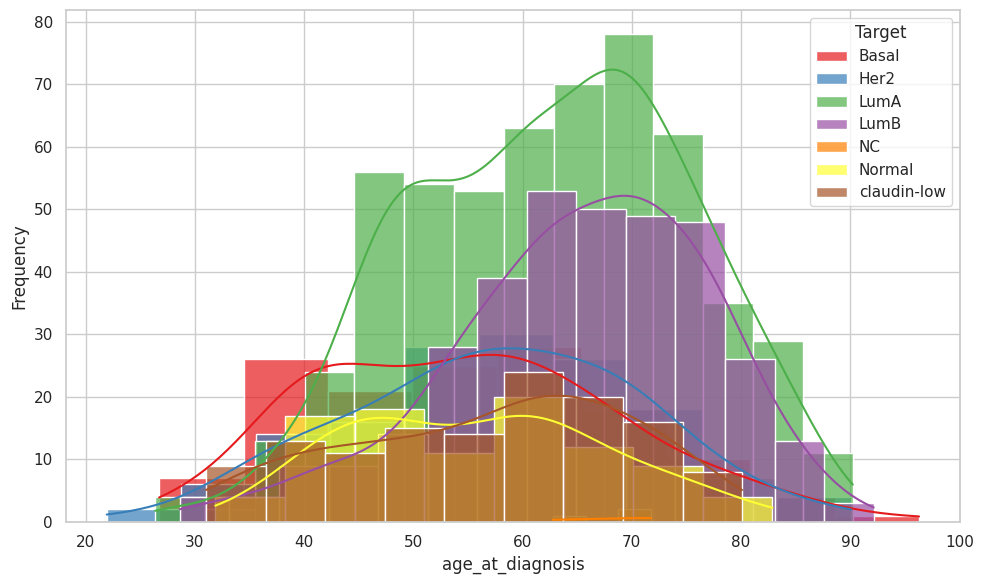

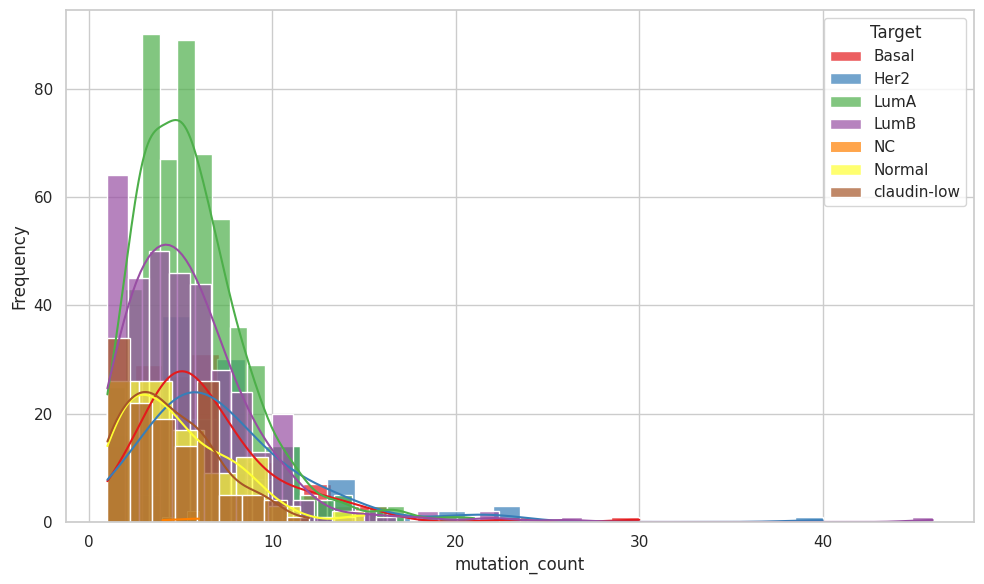

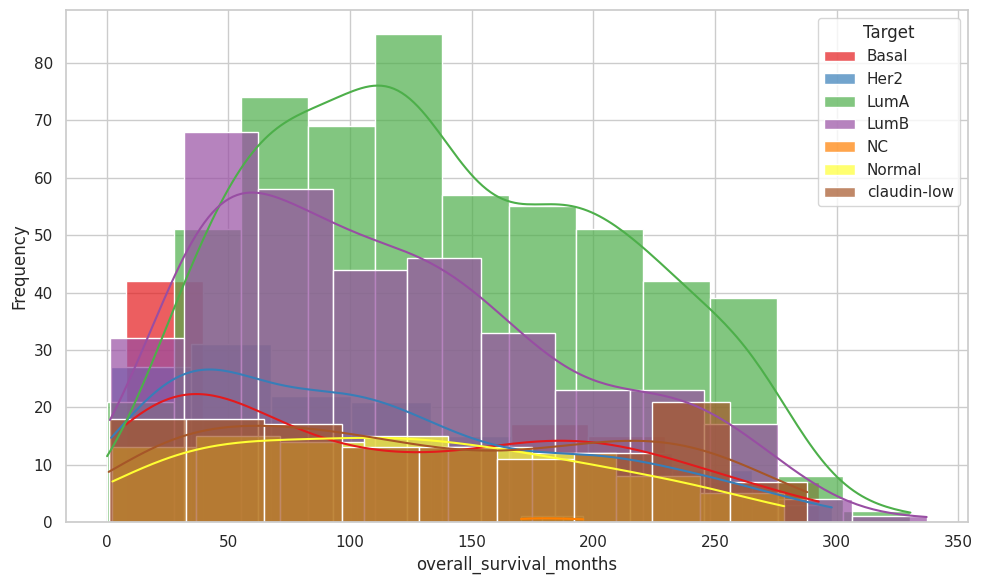

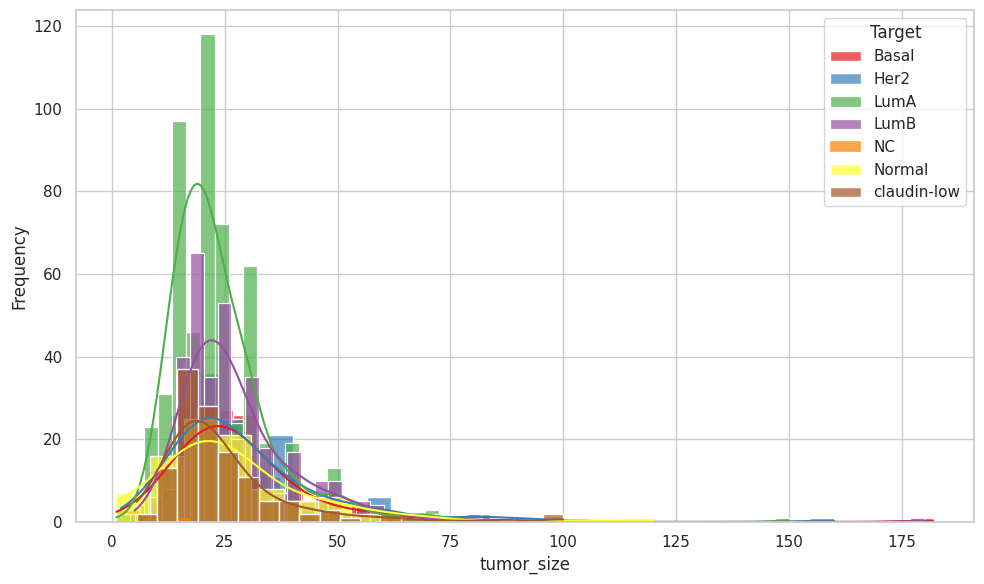

In [17]:

sns.set(style="whitegrid")

# Drop rows with NaN values before plotting
clinical_df_cleaned = clinical_df.dropna()
print(f'Clinical dataframe shape after dropping NaN values: {clinical_df_cleaned.shape}')

for i in clinical_df[['age_at_diagnosis', 'mutation_count', 'overall_survival_months', 'tumor_size']]:
    plt.figure(figsize=(10, 6))  # Create a new figure for each column
    for j in target_values:
        sns.histplot(
            clinical_df_cleaned[i][target_pd_series[clinical_df_cleaned.index] == j],
            color=color_dict[j],
            label=str(j),
            kde=True,
            # bins=30,
            alpha=0.7  # Slight transparency for better overlap visibility
        )
    # plt.title(f'Histogram of {i}', fontsize=16)
    plt.xlabel(i, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.legend(title='Target', loc='best')
    plt.tight_layout()
    plt.show()
    print("\n" * 3)



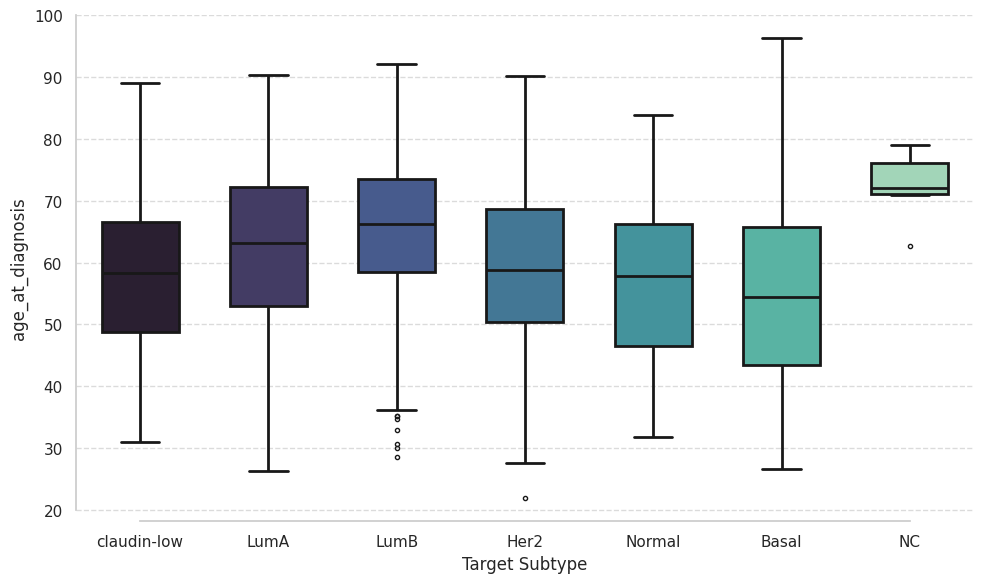

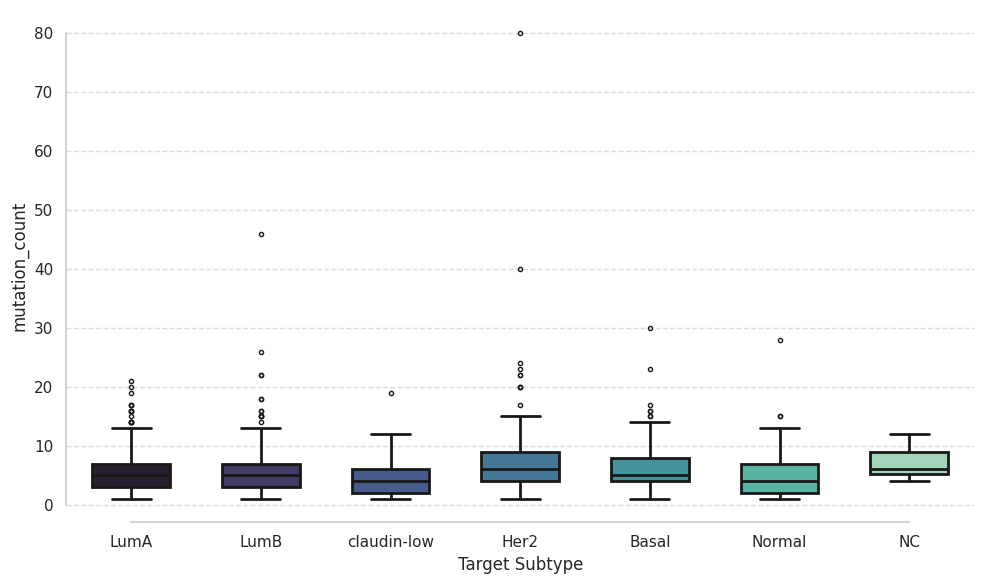

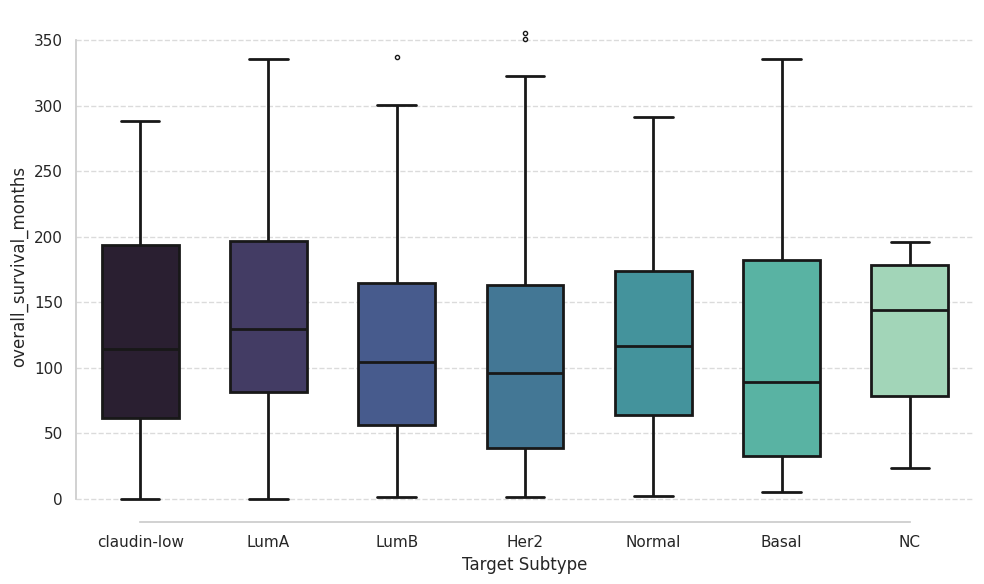

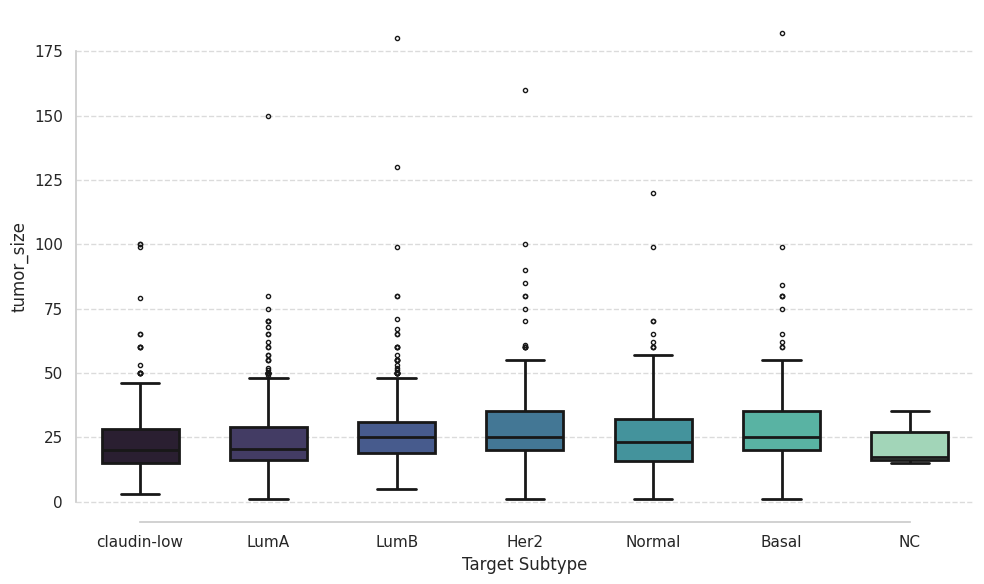

In [18]:
sns.set(style="whitegrid", context="notebook")
palette = sns.color_palette("mako", n_colors=len(target_values))

# sns.set(style="whitegrid", context="notebook")

# # Pick a good categorical palette
# palette = sns.color_palette("Set2", n_colors=len(target_values))

for col in clinical_df[['age_at_diagnosis', 'mutation_count', 'overall_survival_months', 'tumor_size']]:
    plot_df = clinical_df.copy()
    plot_df['target'] = target_pd_series
    plot_df_cleaned = plot_df.dropna(subset=[col, 'target'])

    plt.figure(figsize=(10, 6))

    sns.boxplot(
        x='target',
        y=col,
        hue='target',
        data=plot_df_cleaned,
        palette=palette,
        linewidth=2.0,
        fliersize=3,
        width=0.6
    )

    # plt.title(f'Boxplot of {col} by Target Subtype', fontsize=16, weight='bold')
    plt.xlabel('Target Subtype', fontsize=12)
    plt.ylabel(col, fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    sns.despine(trim=True)
    plt.tight_layout()
    plt.show()
    print("\n" * 2)

Numerical columns: 6 ['age_at_diagnosis', 'lymph_nodes_examined_positive', 'mutation_count', 'nottingham_prognostic_index', 'overall_survival_months', 'tumor_size']
Temporary Clinical dataframe: ['age_at_diagnosis', 'lymph_nodes_examined_positive', 'mutation_count', 'nottingham_prognostic_index', 'overall_survival_months', 'tumor_size', 'target']


/tmp/ipython-input-19-4008117221.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clinical_df_temp['target'] = target_pd_series


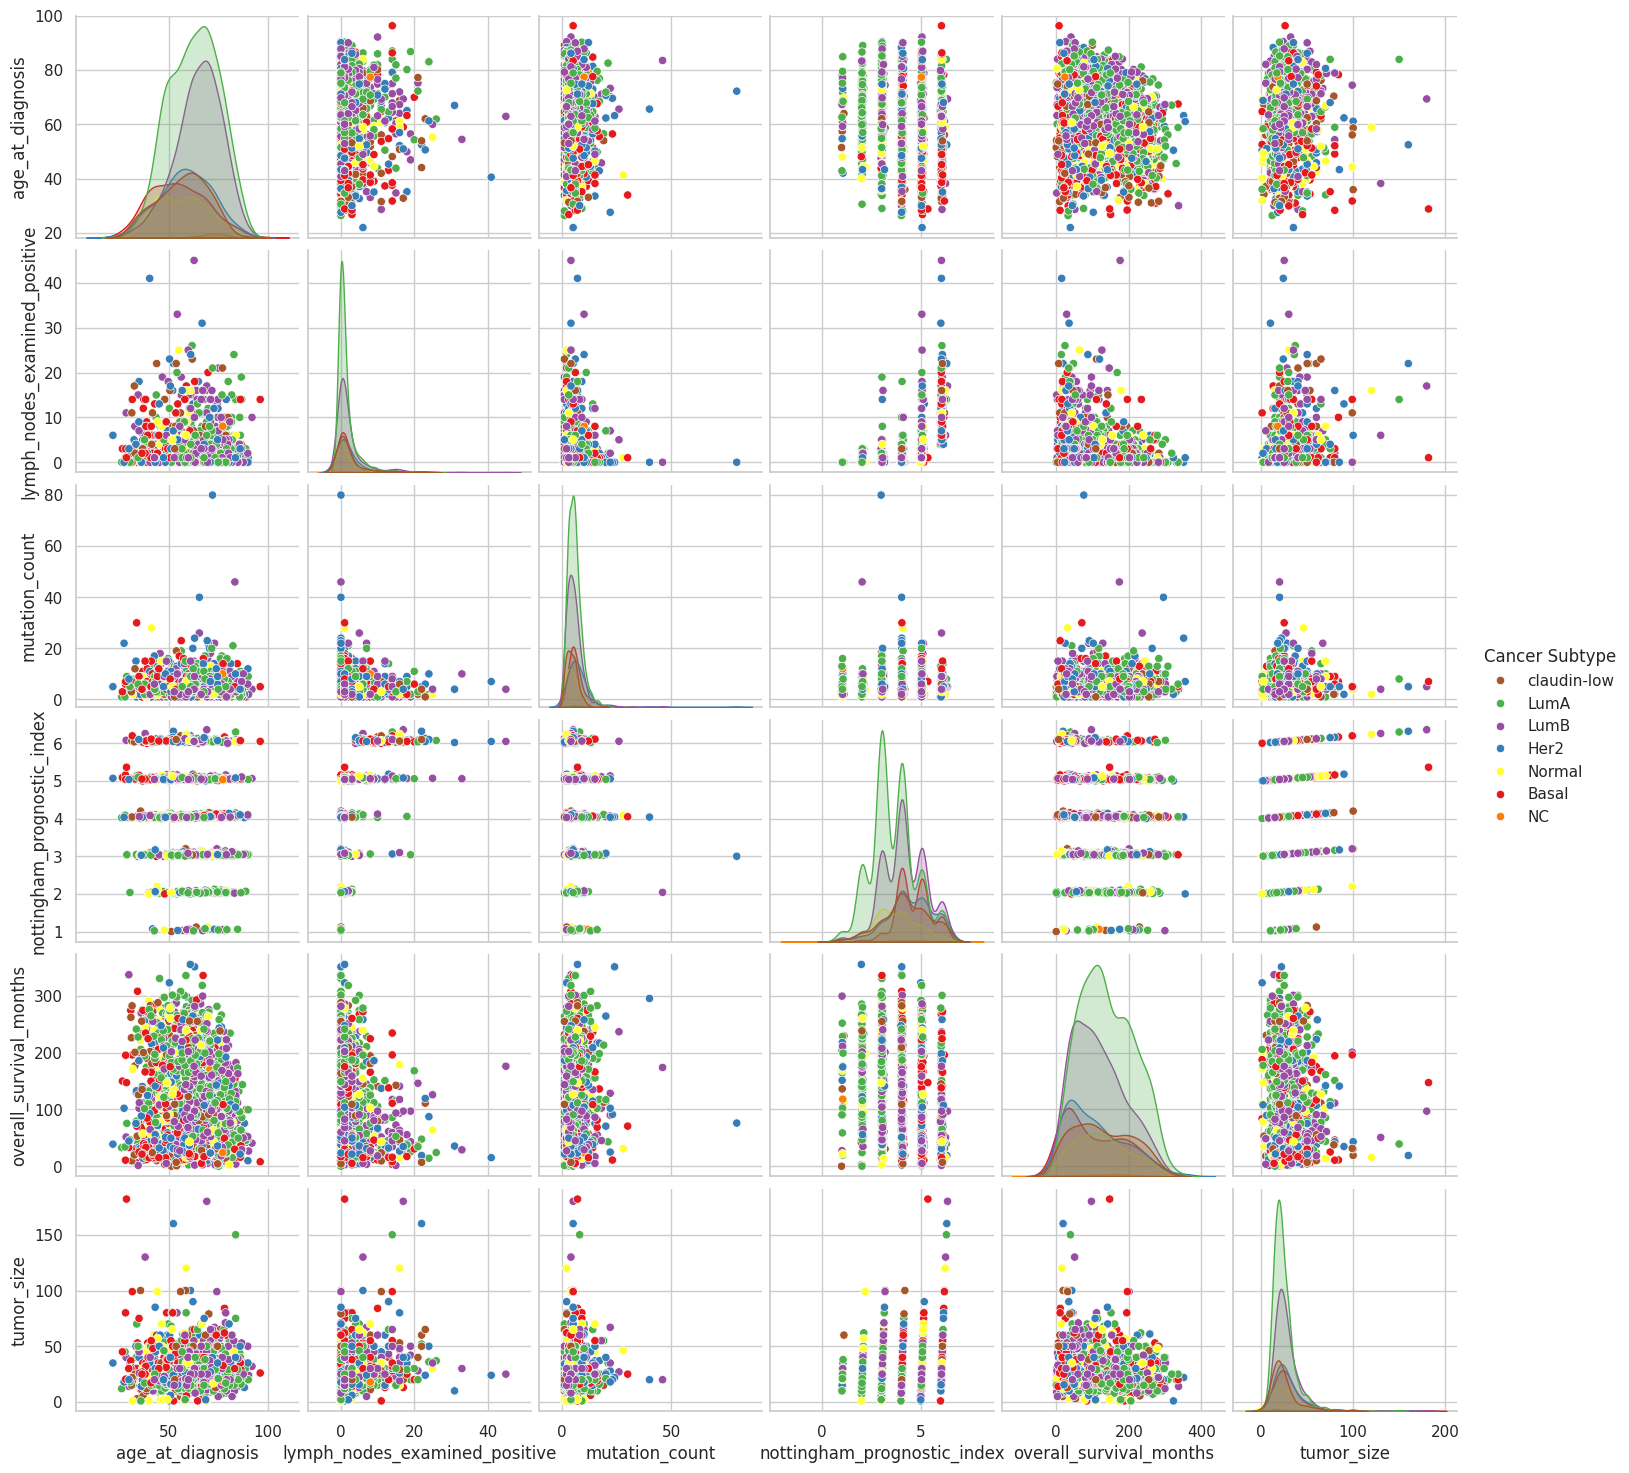

In [19]:
# Pairplot of numerical columns of clinical data
numerical_columns = clinical_df.select_dtypes(include=['float64']).columns.tolist()
print(f'Numerical columns: {len(numerical_columns)} {numerical_columns}')

clinical_df_temp = clinical_df[numerical_columns]
clinical_df_temp['target'] = target_pd_series
print(f'Temporary Clinical dataframe: {clinical_df_temp.columns.tolist()}')

sns.set(style="whitegrid")
pairplot = sns.pairplot(clinical_df_temp, hue='target', palette=color_dict)
new_legend_title = 'Cancer Subtype'
pairplot._legend.set_title(new_legend_title)
plt.show()

### Genes data

1) PCA visualization, colored based on target values

2) UMAP visualization, colored based on target values

3) Clustering using Leiden

4) Clustering using Louvain

5) Clustering metrics

In [20]:
# Quick look
genes_df.head()

,brca1,brca2,palb2,pten,tp53,atm,cdh1,chek2,nbn,nf1,...,srd5a1,srd5a2,srd5a3,st7,star,tnk2,tulp4,ugt2b15,ugt2b17,ugt2b7
patient_id,,,,,,,,,,,,,,,,,,,,,
0,-1.3990,-0.5738,-1.6217,1.4524,0.3504,1.1517,0.0348,0.1266,-0.8361,-0.8578,...,-1.1877,-0.0194,-1.6345,-0.2142,-0.5698,-1.1741,-1.4779,-0.5954,-0.8847,-0.3354
2,-1.3800,0.2777,-1.2154,0.5296,-0.0136,-0.2659,1.3594,0.7961,0.5419,-2.6059,...,-0.4412,0.4534,0.4068,0.7634,0.0231,0.9121,-0.9538,-0.2264,0.5398,-0.8920
5,0.0670,-0.8426,0.2114,-0.3326,0.5141,-0.0803,1.1398,0.4187,-0.4030,-1.1305,...,-0.5381,0.0668,0.8344,1.7227,0.4024,-3.7172,-1.5538,1.3701,-0.1078,0.3655
6,0.6744,-0.5428,-1.6592,0.6369,1.6708,-0.8880,1.2491,-1.1889,-0.4174,-0.6165,...,-0.5630,-0.7078,0.8228,0.6819,-0.1948,-2.3286,-0.9924,-0.3154,0.2320,-0.4828
8,1.2932,-0.9039,-0.7219,0.2168,0.3484,0.3897,0.9131,0.9356,0.7675,-0.2940,...,-0.5845,-0.3544,-1.0150,2.2961,0.1817,-0.1572,0.0427,5.0048,3.8476,1.3223


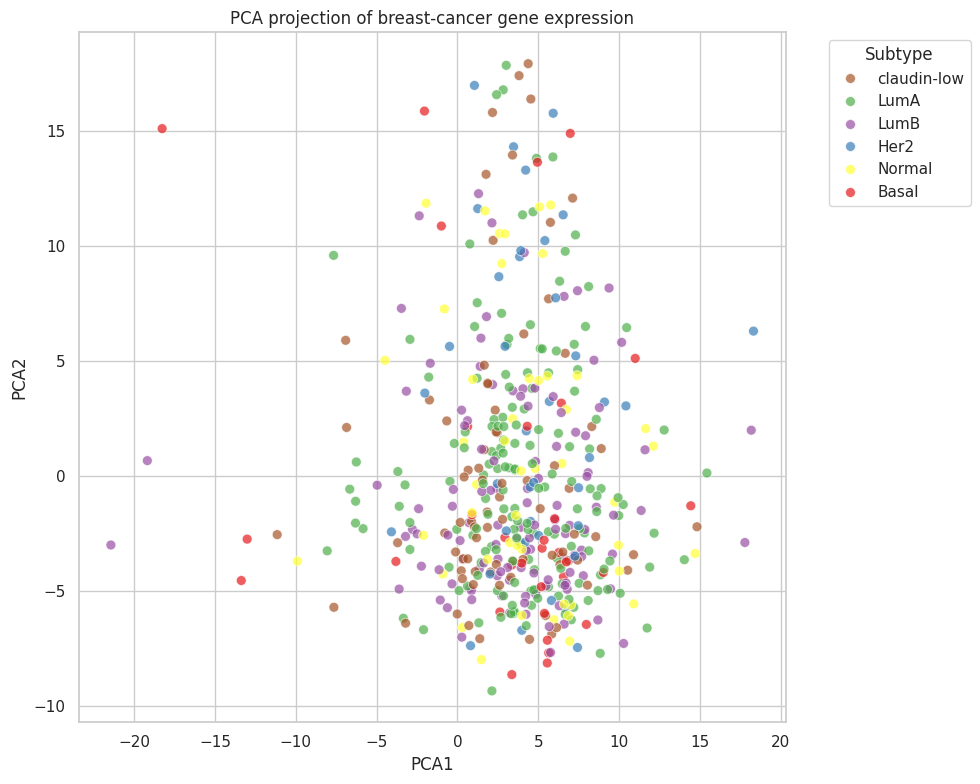

In [21]:
# PCA visualization
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principal_components = pca.fit_transform(genes_df)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
plot_df = pca_df.join(target_pd_series.rename('subtype'))
plt.figure(figsize=(10, 8))

sns.scatterplot(
    x='PC1',
    y='PC2',
    hue='subtype',
    palette=color_dict,
    data=plot_df,
    alpha=0.7,
    s=50
)

plt.title('PCA projection of breast-cancer gene expression')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Subtype', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


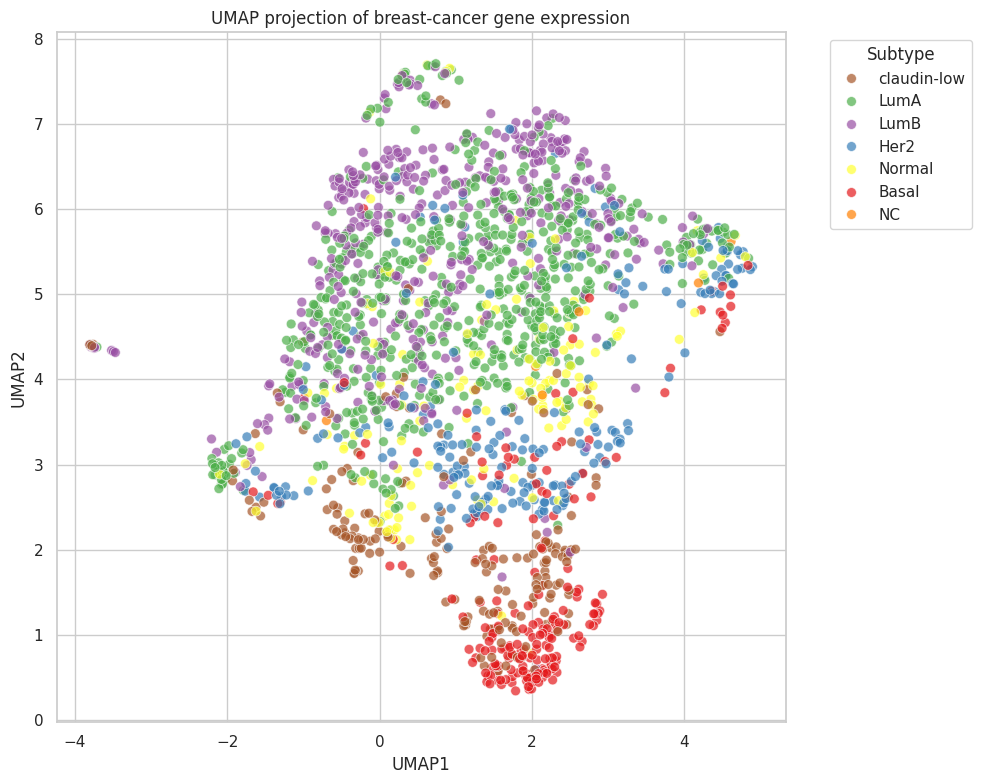

In [22]:
# UMAP visualization
import umap

reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
umap_embedding = reducer.fit_transform(genes_df)
umap_df = pd.DataFrame(umap_embedding, index=genes_df.index, columns=['UMAP1', 'UMAP2'])

plot_df = umap_df.join(target_pd_series.rename('subtype'))

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='UMAP1',
    y='UMAP2',
    hue='subtype',
    palette=color_dict,
    data=plot_df,
    alpha=0.7,
    s=50)

plt.title('UMAP projection of breast-cancer gene expression')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.legend(title='Subtype', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

**CLUSTERING**

Here, the number of genes present in such experiments are generally in the order of 10000. K-mean, GMM, and any other distance metric based clustering algorithms may fail to perform well. In such cases, we use other approaches for clustering. Two of them are Leiden and Louvain clustering, graph based approaches which are highly recommended algorithms for such problems.

For now, we will try k-means and GMM clustering with 7 clusters (7 as that's the number of unique classes we have) and DBSCAN.

In [23]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import (adjusted_rand_score, normalized_mutual_info_score,
                             homogeneity_score, completeness_score, v_measure_score,
                             fowlkes_mallows_score)

In [24]:
target_pd_series.head()

,pam50_+_claudin-low_subtype
patient_id,
0,claudin-low
2,LumA
5,LumB
6,LumB
8,LumB


In [25]:
true_labels = target_pd_series.values

In [26]:
# K-Means clustering
kmeans = KMeans(n_clusters=7, random_state=0).fit(genes_df)
kmeans_labels = kmeans.labels_

In [27]:
# GMM clustering
gmm = GaussianMixture(n_components=7, random_state=0, init_params='k-means++').fit(genes_df)
gmm_labels = gmm.predict(genes_df)

In [28]:
# DBSCAN clustering
dbscan = DBSCAN(eps=100, min_samples=332).fit(genes_df)
dbscan_labels = dbscan.labels_

In [29]:
# Evaluation Function
def evaluate(true, pred, name):
    print(f"--- {name} Clustering ---")
    print("ARI :", adjusted_rand_score(true, pred))
    print("NMI :", normalized_mutual_info_score(true, pred))
    print("Homogeneity :", homogeneity_score(true, pred))
    print("Completeness :", completeness_score(true, pred))
    print("V-Measure :", v_measure_score(true, pred))
    print("Fowlkes-Mallows :", fowlkes_mallows_score(true, pred))
    print()

In [30]:
evaluate(true_labels, kmeans_labels, "K-Means")
evaluate(true_labels, gmm_labels, "GMM")
evaluate(true_labels, dbscan_labels, "DBSCAN")

--- K-Means Clustering ---
ARI : 0.20038513859506646
NMI : 0.30482476481877424
Homogeneity : 0.3142151944727487
Completeness : 0.29597932055758586
V-Measure : 0.3048247648187743
Fowlkes-Mallows : 0.3658499989545137

--- GMM Clustering ---
ARI : 0.16598306744052818
NMI : 0.17516587938687406
Homogeneity : 0.15506923159963895
Completeness : 0.2012470796050757
V-Measure : 0.17516587938687406
Fowlkes-Mallows : 0.4059592544054824

--- DBSCAN Clustering ---
ARI : 0.0
NMI : 0.0
Homogeneity : 0.0
Completeness : 1.0
V-Measure : 0.0
Fowlkes-Mallows : 0.4754025519801211



In [31]:
def plot_umap_individual(X, labels_dict, n_neighbors=15, min_dist=0.1, random_state=42, palette='tab10'):
    """
    UMAP plots for clustering and ground truth, shown separately.

    Args:
        X (ndarray or DataFrame): Feature matrix (no target column).
        labels_dict (dict): Keys are names (e.g., 'Ground Truth', 'KMeans'), values are label arrays.
        n_neighbors (int): UMAP neighbors param.
        min_dist (float): UMAP min_dist param.
        random_state (int): UMAP random seed.
        palette (str or dict): Color palette for seaborn.
    """

    reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, random_state=random_state)
    umap_embedding = reducer.fit_transform(X)

    umap_df = pd.DataFrame(umap_embedding, columns=['UMAP1', 'UMAP2'])

    for name, labels in labels_dict.items():
        plot_df = umap_df.copy()
        plot_df['Label'] = labels

        plt.figure(figsize=(7, 6))
        sns.scatterplot(data=plot_df, x='UMAP1', y='UMAP2', hue='Label',
                        palette=palette, alpha=0.7, s=50)

        plt.title(f"UMAP - {name}")
        plt.xlabel('UMAP1')
        plt.ylabel('UMAP2')
        plt.legend(title=name, bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()
        print("\n\n")


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


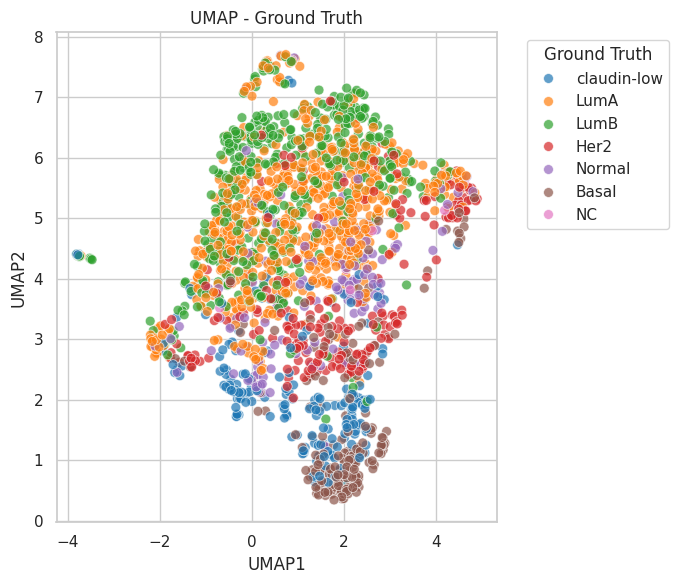

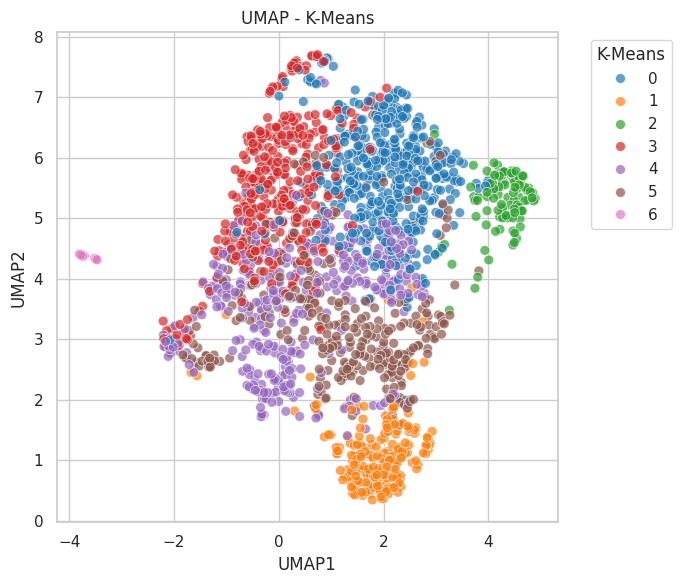

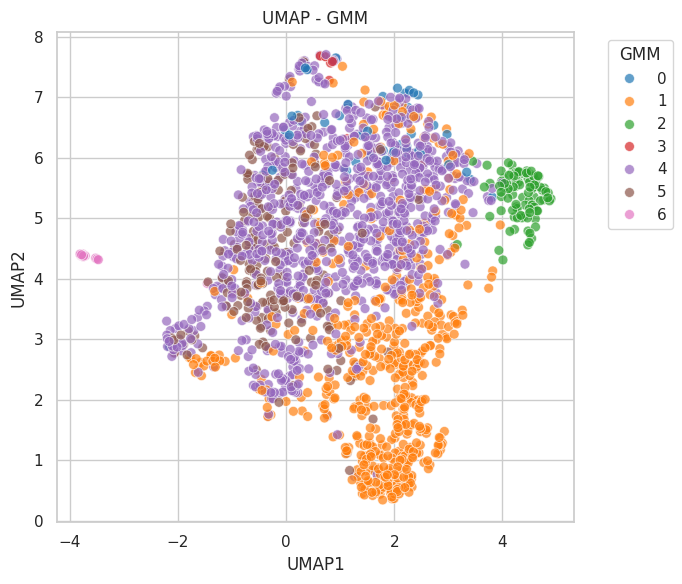

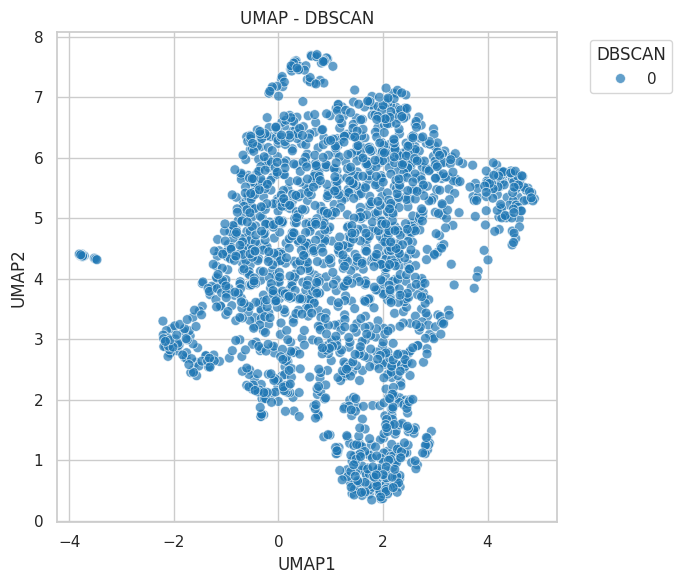

In [32]:
labels_dict = {
    'Ground Truth': true_labels,
    'K-Means': kmeans_labels,
    'GMM': gmm_labels,
    'DBSCAN': dbscan_labels
}

plot_umap_individual(genes_df, labels_dict)

## Train-test splitting

In [33]:
# First combine the two modes of data clinical data and genes data to get the main dataset
X = pd.concat([clinical_df, genes_df], axis=1)
print(f'X dataframe: {X.shape}, {X.index.name}, {X.columns.tolist()}')

y = target_pd_series
print(f'y dataframe: {y.shape}, {y.index.name}, {y.name}')

# Now split the dataset into train and test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'X_train dataframe: {X_train.shape}, {X_train.index.name}, {X_train.columns.tolist()}')
print(f'y_train dataframe: {y_train.shape}, {y_train.index.name}, {y_train.name}')

print(f'X_test dataframe: {X_test.shape}, {X_test.index.name}, {X_test.columns.tolist()}')
print(f'y_test dataframe: {y_test.shape}, {y_test.index.name}, {y_test.name}')

X dataframe: (1904, 517), patient_id, ['age_at_diagnosis', 'type_of_breast_surgery', 'cancer_type', 'cancer_type_detailed', 'cellularity', 'chemotherapy', 'cohort', 'er_status_measured_by_ihc', 'er_status', 'neoplasm_histologic_grade', 'her2_status_measured_by_snp6', 'her2_status', 'tumor_other_histologic_subtype', 'hormone_therapy', 'inferred_menopausal_state', 'integrative_cluster', 'primary_tumor_laterality', 'lymph_nodes_examined_positive', 'mutation_count', 'nottingham_prognostic_index', 'oncotree_code', 'overall_survival_months', 'overall_survival', 'pr_status', 'radio_therapy', '3-gene_classifier_subtype', 'tumor_size', 'death_from_cancer', 'brca1', 'brca2', 'palb2', 'pten', 'tp53', 'atm', 'cdh1', 'chek2', 'nbn', 'nf1', 'stk11', 'bard1', 'mlh1', 'msh2', 'msh6', 'pms2', 'epcam', 'rad51c', 'rad51d', 'rad50', 'rb1', 'rbl1', 'rbl2', 'ccna1', 'ccnb1', 'cdk1', 'ccne1', 'cdk2', 'cdc25a', 'ccnd1', 'cdk4', 'cdk6', 'ccnd2', 'cdkn2a', 'cdkn2b', 'myc', 'cdkn1a', 'cdkn1b', 'e2f1', 'e2f2', 'e

## Pre-processing of clinical data

1) Imputation

2) Outlier treatment using IQR clipping

3) Scaling

### Imputation

In [34]:
# Imputation using KNN for numerical features of clinical data
numerical_features = clinical_df.select_dtypes(include=['float64']).columns
categorical_features = clinical_df.select_dtypes(include=['object', 'boolean']).columns

# For numerical data imputation
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5)
X_train[numerical_features] = imputer.fit_transform(X_train[numerical_features])
X_test[numerical_features] = imputer.transform(X_test[numerical_features])

# For categorical data imputation
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='most_frequent')
X_train[categorical_features] = imputer.fit_transform(X_train[categorical_features])
X_test[categorical_features] = imputer.transform(X_test[categorical_features])

In [35]:
basic_checks(X_train)

Dataframe check: (1523, 517), patient_id, ['age_at_diagnosis', 'type_of_breast_surgery', 'cancer_type', 'cancer_type_detailed', 'cellularity', 'chemotherapy', 'cohort', 'er_status_measured_by_ihc', 'er_status', 'neoplasm_histologic_grade', 'her2_status_measured_by_snp6', 'her2_status', 'tumor_other_histologic_subtype', 'hormone_therapy', 'inferred_menopausal_state', 'integrative_cluster', 'primary_tumor_laterality', 'lymph_nodes_examined_positive', 'mutation_count', 'nottingham_prognostic_index', 'oncotree_code', 'overall_survival_months', 'overall_survival', 'pr_status', 'radio_therapy', '3-gene_classifier_subtype', 'tumor_size', 'death_from_cancer', 'brca1', 'brca2', 'palb2', 'pten', 'tp53', 'atm', 'cdh1', 'chek2', 'nbn', 'nf1', 'stk11', 'bard1', 'mlh1', 'msh2', 'msh6', 'pms2', 'epcam', 'rad51c', 'rad51d', 'rad50', 'rb1', 'rbl1', 'rbl2', 'ccna1', 'ccnb1', 'cdk1', 'ccne1', 'cdk2', 'cdc25a', 'ccnd1', 'cdk4', 'cdk6', 'ccnd2', 'cdkn2a', 'cdkn2b', 'myc', 'cdkn1a', 'cdkn1b', 'e2f1', 'e2f2'

In [36]:
X_train.isna().sum().sum()

np.int64(0)

In [37]:
X_train.describe()

,age_at_diagnosis,lymph_nodes_examined_positive,mutation_count,nottingham_prognostic_index,overall_survival_months,tumor_size,brca1,brca2,palb2,pten,...,srd5a1,srd5a2,srd5a3,st7,star,tnk2,tulp4,ugt2b15,ugt2b17,ugt2b7
count,1523.000000,1523.000000,1523.000000,1523.000000,1523.000000,1523.000000,1523.000000,1523.000000,1523.000000,1523.000000,...,1523.000000,1523.000000,1523.000000,1523.000000,1523.000000,1523.000000,1523.000000,1523.000000,1523.000000,1523.000000
mean,61.203283,2.028234,5.827708,4.019258,126.218626,26.346100,-0.007519,-0.009402,0.005342,0.006691,...,-0.003426,0.003666,-0.006837,0.003466,0.005173,0.001018,0.007646,0.017669,0.012066,0.009787
std,12.939164,4.168257,4.262534,1.156107,76.806354,14.926478,1.008816,0.991187,1.000841,0.994604,...,1.008780,0.970546,1.010699,1.005809,1.021238,1.006227,1.004993,1.012077,0.989599,1.009759
min,21.930000,0.000000,1.000000,1.000000,0.000000,1.000000,-2.444400,-2.558400,-4.384600,-5.932800,...,-2.120800,-3.364800,-2.719400,-4.982700,-2.981700,-3.833300,-3.609300,-1.166900,-2.112600,-1.051600
25%,51.580000,0.000000,3.000000,3.046000,61.966667,17.650000,-0.725000,-0.705650,-0.661650,-0.566100,...,-0.626400,-0.605900,-0.702950,-0.607150,-0.632500,-0.668850,-0.710850,-0.505250,-0.455750,-0.725700
50%,61.780000,0.000000,5.000000,4.042000,116.533333,23.000000,-0.124900,-0.072400,-0.011300,0.113900,...,-0.250500,-0.049900,-0.151800,-0.057800,-0.032300,0.003500,-0.010300,-0.278800,-0.114000,-0.418000
75%,70.650000,2.000000,7.000000,5.040500,186.250000,30.000000,0.532300,0.621350,0.631500,0.657400,...,0.317400,0.518550,0.523500,0.577900,0.601650,0.669850,0.606050,0.067700,0.282950,0.439550
max,96.290000,45.000000,80.000000,6.320000,355.200000,182.000000,4.554200,3.654900,4.615000,3.254100,...,6.534900,9.493500,6.329000,4.571300,12.742300,3.938800,3.833400,8.619900,12.643900,3.284400


In [38]:
basic_checks(X_test)

Dataframe check: (381, 517), patient_id, ['age_at_diagnosis', 'type_of_breast_surgery', 'cancer_type', 'cancer_type_detailed', 'cellularity', 'chemotherapy', 'cohort', 'er_status_measured_by_ihc', 'er_status', 'neoplasm_histologic_grade', 'her2_status_measured_by_snp6', 'her2_status', 'tumor_other_histologic_subtype', 'hormone_therapy', 'inferred_menopausal_state', 'integrative_cluster', 'primary_tumor_laterality', 'lymph_nodes_examined_positive', 'mutation_count', 'nottingham_prognostic_index', 'oncotree_code', 'overall_survival_months', 'overall_survival', 'pr_status', 'radio_therapy', '3-gene_classifier_subtype', 'tumor_size', 'death_from_cancer', 'brca1', 'brca2', 'palb2', 'pten', 'tp53', 'atm', 'cdh1', 'chek2', 'nbn', 'nf1', 'stk11', 'bard1', 'mlh1', 'msh2', 'msh6', 'pms2', 'epcam', 'rad51c', 'rad51d', 'rad50', 'rb1', 'rbl1', 'rbl2', 'ccna1', 'ccnb1', 'cdk1', 'ccne1', 'cdk2', 'cdc25a', 'ccnd1', 'cdk4', 'cdk6', 'ccnd2', 'cdkn2a', 'cdkn2b', 'myc', 'cdkn1a', 'cdkn1b', 'e2f1', 'e2f2',

In [39]:
X_test.isna().sum().sum()

np.int64(0)

In [40]:
X_test.describe()

,age_at_diagnosis,lymph_nodes_examined_positive,mutation_count,nottingham_prognostic_index,overall_survival_months,tumor_size,brca1,brca2,palb2,pten,...,srd5a1,srd5a2,srd5a3,st7,star,tnk2,tulp4,ugt2b15,ugt2b17,ugt2b7
count,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,...,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000
mean,60.622441,1.897638,5.235696,4.088023,120.734996,25.881916,0.030053,0.037581,-0.021352,-0.026750,...,0.013696,-0.014655,0.027326,-0.013854,-0.020687,-0.004069,-0.030562,-0.070627,-0.048234,-0.039124
std,13.142490,3.709521,2.999155,1.096581,74.353774,15.826830,0.966018,1.036230,0.998977,1.023461,...,0.966638,1.112408,0.958207,0.978956,0.912573,0.977352,0.981830,0.949573,1.041741,0.961654
min,28.290000,0.000000,1.000000,1.030000,1.433333,1.000000,-2.210900,-2.783500,-3.704100,-5.262300,...,-1.446700,-2.754400,-1.848400,-4.411300,-2.936400,-2.776600,-2.635500,-1.001600,-1.798000,-1.005700
25%,50.920000,0.000000,3.000000,3.050000,57.300000,17.000000,-0.664900,-0.663500,-0.717500,-0.512600,...,-0.571600,-0.628600,-0.560900,-0.630000,-0.649100,-0.644800,-0.702300,-0.509000,-0.519100,-0.734200
50%,61.220000,1.000000,5.000000,4.044000,111.866667,22.000000,-0.115600,0.023000,-0.046700,0.098000,...,-0.229800,-0.035800,-0.093900,-0.022900,0.031500,-0.020900,-0.097300,-0.323800,-0.215500,-0.451700
75%,70.420000,2.000000,7.000000,5.040000,175.900000,30.000000,0.617000,0.674000,0.683000,0.607700,...,0.350200,0.501600,0.455300,0.579300,0.560500,0.580100,0.525700,-0.016500,0.230400,0.342400
max,90.230000,31.000000,22.000000,6.360000,337.033333,180.000000,3.171100,3.737900,3.867600,2.315800,...,5.298600,10.270300,5.272400,3.015000,3.476300,3.240300,3.811400,10.884900,11.654600,3.177300


### Outlier treatment using IQR clipping

In [41]:
def get_iqr_bounds(df, columns=None):
    """Compute IQR clipping bounds from a DataFrame."""
    bounds = {}
    if columns is None:
        columns = df.select_dtypes(include='number').columns

    for col in columns:
        iqr = df[col].quantile(0.75) - df[col].quantile(0.25)
        lower = df[col].quantile(0.25) - 1.5*iqr
        upper = df[col].quantile(0.75) + 1.5*iqr

        bounds[col] = (lower, upper)

    return bounds

def apply_iqr_clipping(df, bounds):
    """Apply precomputed IQR bounds to clip the DataFrame."""
    df_clipped = df.copy()
    for col, (lower, upper) in bounds.items():
        if col in df.columns:
            df_clipped[col] = df[col].apply(
                lambda x: lower if pd.notna(x) and x < lower else
                          upper if pd.notna(x) and x > upper else
                          x
            )
    return df_clipped


In [42]:
iqr_bounds = get_iqr_bounds(X_train, columns=numerical_features)
X_train_clipped = apply_iqr_clipping(X_train, iqr_bounds)
X_test_clipped = apply_iqr_clipping(X_test, iqr_bounds)

In [43]:
print(f'X_train_clipped dataframe: {X_train_clipped.shape}, {X_train_clipped.index.name}, {X_train_clipped.columns.tolist()}')
print(f'X_test_clipped dataframe: {X_test_clipped.shape}, {X_test_clipped.index.name}, {X_test_clipped.columns.tolist()}')

X_train_clipped dataframe: (1523, 517), patient_id, ['age_at_diagnosis', 'type_of_breast_surgery', 'cancer_type', 'cancer_type_detailed', 'cellularity', 'chemotherapy', 'cohort', 'er_status_measured_by_ihc', 'er_status', 'neoplasm_histologic_grade', 'her2_status_measured_by_snp6', 'her2_status', 'tumor_other_histologic_subtype', 'hormone_therapy', 'inferred_menopausal_state', 'integrative_cluster', 'primary_tumor_laterality', 'lymph_nodes_examined_positive', 'mutation_count', 'nottingham_prognostic_index', 'oncotree_code', 'overall_survival_months', 'overall_survival', 'pr_status', 'radio_therapy', '3-gene_classifier_subtype', 'tumor_size', 'death_from_cancer', 'brca1', 'brca2', 'palb2', 'pten', 'tp53', 'atm', 'cdh1', 'chek2', 'nbn', 'nf1', 'stk11', 'bard1', 'mlh1', 'msh2', 'msh6', 'pms2', 'epcam', 'rad51c', 'rad51d', 'rad50', 'rb1', 'rbl1', 'rbl2', 'ccna1', 'ccnb1', 'cdk1', 'ccne1', 'cdk2', 'cdc25a', 'ccnd1', 'cdk4', 'cdk6', 'ccnd2', 'cdkn2a', 'cdkn2b', 'myc', 'cdkn1a', 'cdkn1b', 'e2f

In [44]:
X_train_clipped.describe()

,age_at_diagnosis,lymph_nodes_examined_positive,mutation_count,nottingham_prognostic_index,overall_survival_months,tumor_size,brca1,brca2,palb2,pten,...,srd5a1,srd5a2,srd5a3,st7,star,tnk2,tulp4,ugt2b15,ugt2b17,ugt2b7
count,1523.000000,1523.000000,1523.000000,1523.000000,1523.000000,1523.000000,1523.000000,1523.000000,1523.000000,1523.000000,...,1523.000000,1523.000000,1523.000000,1523.000000,1523.000000,1523.000000,1523.000000,1523.000000,1523.000000,1523.000000
mean,61.203969,1.298752,5.585555,4.019258,126.218626,25.150433,-0.007519,-0.009402,0.005342,0.006691,...,-0.003426,0.003666,-0.006837,0.003466,0.005173,0.001018,0.007646,0.017669,0.012066,0.009787
std,12.937107,1.782723,3.041664,1.156107,76.806354,10.668321,1.008816,0.991187,1.000841,0.994604,...,1.008780,0.970546,1.010699,1.005809,1.021238,1.006227,1.004993,1.012077,0.989599,1.009759
min,22.975000,0.000000,1.000000,1.000000,0.000000,1.000000,-2.444400,-2.558400,-4.384600,-5.932800,...,-2.120800,-3.364800,-2.719400,-4.982700,-2.981700,-3.833300,-3.609300,-1.166900,-2.112600,-1.051600
25%,51.580000,0.000000,3.000000,3.046000,61.966667,17.650000,-0.725000,-0.705650,-0.661650,-0.566100,...,-0.626400,-0.605900,-0.702950,-0.607150,-0.632500,-0.668850,-0.710850,-0.505250,-0.455750,-0.725700
50%,61.780000,0.000000,5.000000,4.042000,116.533333,23.000000,-0.124900,-0.072400,-0.011300,0.113900,...,-0.250500,-0.049900,-0.151800,-0.057800,-0.032300,0.003500,-0.010300,-0.278800,-0.114000,-0.418000
75%,70.650000,2.000000,7.000000,5.040500,186.250000,30.000000,0.532300,0.621350,0.631500,0.657400,...,0.317400,0.518550,0.523500,0.577900,0.601650,0.669850,0.606050,0.067700,0.282950,0.439550
max,96.290000,5.000000,13.000000,6.320000,355.200000,48.525000,4.554200,3.654900,4.615000,3.254100,...,6.534900,9.493500,6.329000,4.571300,12.742300,3.938800,3.833400,8.619900,12.643900,3.284400


In [45]:
X_test_clipped.describe()

,age_at_diagnosis,lymph_nodes_examined_positive,mutation_count,nottingham_prognostic_index,overall_survival_months,tumor_size,brca1,brca2,palb2,pten,...,srd5a1,srd5a2,srd5a3,st7,star,tnk2,tulp4,ugt2b15,ugt2b17,ugt2b7
count,381.000000,381.00000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,...,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000
mean,60.622441,1.28084,5.170079,4.088023,120.734996,24.651142,0.030053,0.037581,-0.021352,-0.026750,...,0.013696,-0.014655,0.027326,-0.013854,-0.020687,-0.004069,-0.030562,-0.070627,-0.048234,-0.039124
std,13.142490,1.71905,2.753571,1.096581,74.353774,10.603922,0.966018,1.036230,0.998977,1.023461,...,0.966638,1.112408,0.958207,0.978956,0.912573,0.977352,0.981830,0.949573,1.041741,0.961654
min,28.290000,0.00000,1.000000,1.030000,1.433333,1.000000,-2.210900,-2.783500,-3.704100,-5.262300,...,-1.446700,-2.754400,-1.848400,-4.411300,-2.936400,-2.776600,-2.635500,-1.001600,-1.798000,-1.005700
25%,50.920000,0.00000,3.000000,3.050000,57.300000,17.000000,-0.664900,-0.663500,-0.717500,-0.512600,...,-0.571600,-0.628600,-0.560900,-0.630000,-0.649100,-0.644800,-0.702300,-0.509000,-0.519100,-0.734200
50%,61.220000,1.00000,5.000000,4.044000,111.866667,22.000000,-0.115600,0.023000,-0.046700,0.098000,...,-0.229800,-0.035800,-0.093900,-0.022900,0.031500,-0.020900,-0.097300,-0.323800,-0.215500,-0.451700
75%,70.420000,2.00000,7.000000,5.040000,175.900000,30.000000,0.617000,0.674000,0.683000,0.607700,...,0.350200,0.501600,0.455300,0.579300,0.560500,0.580100,0.525700,-0.016500,0.230400,0.342400
max,90.230000,5.00000,13.000000,6.360000,337.033333,48.525000,3.171100,3.737900,3.867600,2.315800,...,5.298600,10.270300,5.272400,3.015000,3.476300,3.240300,3.811400,10.884900,11.654600,3.177300


### Scaling

In [46]:
from sklearn.preprocessing import StandardScaler

scaler_clinical = StandardScaler()

X_train_scaled = X_train_clipped.copy()
X_test_scaled = X_test_clipped.copy()
X_train_scaled[numerical_features] = scaler_clinical.fit_transform(X_train_clipped[numerical_features])
X_test_scaled[numerical_features] = scaler_clinical.transform(X_test_clipped[numerical_features])

In [47]:
X_train_scaled.head()

,age_at_diagnosis,type_of_breast_surgery,cancer_type,cancer_type_detailed,cellularity,chemotherapy,cohort,er_status_measured_by_ihc,er_status,neoplasm_histologic_grade,...,srd5a1,srd5a2,srd5a3,st7,star,tnk2,tulp4,ugt2b15,ugt2b17,ugt2b7
patient_id,,,,,,,,,,,,,,,,,,,,,
7005,0.745081,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,High,False,4.0,Positve,Positive,1.0,...,-0.3636,-0.2750,0.5169,0.0289,0.6232,-1.8850,-0.6595,-0.1414,-0.6469,-0.3547
7122,1.715478,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,Moderate,False,4.0,Positve,Positive,3.0,...,0.3481,-0.5102,-0.0840,-1.1180,0.8793,0.0263,-0.8611,-0.5928,-0.2279,-0.3010
501,-0.949053,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,Moderate,True,1.0,Positve,Positive,3.0,...,-1.0781,-0.7645,0.8331,0.6420,0.9622,0.5971,0.6334,-0.4991,-0.3602,2.2400
5366,1.110043,MASTECTOMY,Breast Cancer,Breast Invasive Lobular Carcinoma,High,False,3.0,Positve,Positive,3.0,...,0.0776,-1.0935,0.9003,-0.8902,-0.6239,0.3363,1.3768,-0.4588,-0.5091,-0.7378
5300,-0.438725,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,Moderate,False,3.0,Positve,Positive,1.0,...,-0.2608,-0.1005,0.0862,-0.2726,1.8126,0.0107,-0.8228,-0.5810,-0.3369,-0.9197


In [48]:
X_test_scaled.describe()

,age_at_diagnosis,lymph_nodes_examined_positive,mutation_count,nottingham_prognostic_index,overall_survival_months,tumor_size,brca1,brca2,palb2,pten,...,srd5a1,srd5a2,srd5a3,st7,star,tnk2,tulp4,ugt2b15,ugt2b17,ugt2b7
count,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,...,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000
mean,-0.044965,-0.010051,-0.136640,0.059499,-0.071419,-0.046817,0.030053,0.037581,-0.021352,-0.026750,...,0.013696,-0.014655,0.027326,-0.013854,-0.020687,-0.004069,-0.030562,-0.070627,-0.048234,-0.039124
std,1.016209,0.964600,0.905582,0.948824,0.968386,0.994290,0.966018,1.036230,0.998977,1.023461,...,0.966638,1.112408,0.958207,0.978956,0.912573,0.977352,0.981830,0.949573,1.041741,0.961654
min,-2.544988,-0.728761,-1.508076,-2.586475,-1.625208,-2.264496,-2.210900,-2.783500,-3.704100,-5.262300,...,-1.446700,-2.754400,-1.848400,-4.411300,-2.936400,-2.776600,-2.635500,-1.001600,-1.798000,-1.005700
25%,-0.795181,-0.728761,-0.850325,-0.838657,-0.897598,-0.764236,-0.664900,-0.663500,-0.717500,-0.512600,...,-0.571600,-0.628600,-0.560900,-0.630000,-0.649100,-0.644800,-0.702300,-0.509000,-0.519100,-0.734200
50%,0.001240,-0.167637,-0.192575,0.021408,-0.186920,-0.295404,-0.115600,0.023000,-0.046700,0.098000,...,-0.229800,-0.035800,-0.093900,-0.022900,0.031500,-0.020900,-0.097300,-0.323800,-0.215500,-0.451700
75%,0.712606,0.393487,0.465176,0.883203,0.647052,0.454726,0.617000,0.674000,0.683000,0.607700,...,0.350200,0.501600,0.455300,0.579300,0.560500,0.580100,0.525700,-0.016500,0.230400,0.342400
max,2.244363,2.076859,2.438428,2.025341,2.745658,2.191745,3.171100,3.737900,3.867600,2.315800,...,5.298600,10.270300,5.272400,3.015000,3.476300,3.240300,3.811400,10.884900,11.654600,3.177300


### Correlation handling

In [49]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import pandas as pd

def get_high_vif_features(df, features=None, threshold=5.0):
    """
    Returns a list of features with VIF above the threshold.

    Parameters:
        df (pd.DataFrame): DataFrame with features.
        features (list): List of features to check. If None, use numeric columns.
        threshold (float): VIF threshold above which features are considered multicollinear.

    Returns:
        List[str]: Features to drop based on VIF.
    """
    if features is None:
        features = df.select_dtypes(include='number').columns.tolist()

    X = add_constant(df[features])
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    # Drop the constant term (intercept) from the result
    vif_data = vif_data[vif_data["feature"] != "const"]

    # Get features with VIF above threshold
    high_vif_features = vif_data[vif_data["VIF"] > threshold]["feature"].tolist()

    return high_vif_features

features_to_drop = get_high_vif_features(X_train_scaled[numerical_features], threshold=5.0)
print("Drop these features due to high multicollinearity:", len(features_to_drop), features_to_drop)

Drop these features due to high multicollinearity: 0 []


In [50]:
X_train_scaled.drop(columns=features_to_drop, errors='ignore')
X_test_scaled.drop(columns=features_to_drop,  errors='ignore')

print(f'X_train_scaled dataframe: {X_train_scaled.shape}, {X_train_scaled.index.name}, {X_train_scaled.columns.tolist()}')
print(f'X_test_scaled dataframe: {X_test_scaled.shape}, {X_test_scaled.index.name}, {X_test_scaled.columns.tolist()}')

X_train_scaled dataframe: (1523, 517), patient_id, ['age_at_diagnosis', 'type_of_breast_surgery', 'cancer_type', 'cancer_type_detailed', 'cellularity', 'chemotherapy', 'cohort', 'er_status_measured_by_ihc', 'er_status', 'neoplasm_histologic_grade', 'her2_status_measured_by_snp6', 'her2_status', 'tumor_other_histologic_subtype', 'hormone_therapy', 'inferred_menopausal_state', 'integrative_cluster', 'primary_tumor_laterality', 'lymph_nodes_examined_positive', 'mutation_count', 'nottingham_prognostic_index', 'oncotree_code', 'overall_survival_months', 'overall_survival', 'pr_status', 'radio_therapy', '3-gene_classifier_subtype', 'tumor_size', 'death_from_cancer', 'brca1', 'brca2', 'palb2', 'pten', 'tp53', 'atm', 'cdh1', 'chek2', 'nbn', 'nf1', 'stk11', 'bard1', 'mlh1', 'msh2', 'msh6', 'pms2', 'epcam', 'rad51c', 'rad51d', 'rad50', 'rb1', 'rbl1', 'rbl2', 'ccna1', 'ccnb1', 'cdk1', 'ccne1', 'cdk2', 'cdc25a', 'ccnd1', 'cdk4', 'cdk6', 'ccnd2', 'cdkn2a', 'cdkn2b', 'myc', 'cdkn1a', 'cdkn1b', 'e2f1

### Encoding categorical data

In [51]:
categorical_features = X_train_scaled.select_dtypes(include=['object']).columns
print(f'Categorical features: {len(categorical_features)} {categorical_features}')

Categorical features: 22 Index(['type_of_breast_surgery', 'cancer_type', 'cancer_type_detailed',
       'cellularity', 'chemotherapy', 'cohort', 'er_status_measured_by_ihc',
       'er_status', 'neoplasm_histologic_grade',
       'her2_status_measured_by_snp6', 'her2_status',
       'tumor_other_histologic_subtype', 'hormone_therapy',
       'inferred_menopausal_state', 'integrative_cluster',
       'primary_tumor_laterality', 'oncotree_code', 'overall_survival',
       'pr_status', 'radio_therapy', '3-gene_classifier_subtype',
       'death_from_cancer'],
      dtype='object')


In [52]:
# Convert object data to one-hot encoded columns
X_train_encoded = pd.get_dummies(X_train_scaled, columns=categorical_features)
X_test_encoded = pd.get_dummies(X_test_scaled, columns=categorical_features)

print(f'X_train_encoded dataframe: {X_train_encoded.shape}, {X_train_encoded.index.name}, {X_train_encoded.columns.tolist()}')
print(f'X_test_encoded dataframe: {X_test_encoded.shape}, {X_test_encoded.index.name}, {X_test_encoded.columns.tolist()}')

X_train_encoded dataframe: (1523, 572), patient_id, ['age_at_diagnosis', 'lymph_nodes_examined_positive', 'mutation_count', 'nottingham_prognostic_index', 'overall_survival_months', 'tumor_size', 'brca1', 'brca2', 'palb2', 'pten', 'tp53', 'atm', 'cdh1', 'chek2', 'nbn', 'nf1', 'stk11', 'bard1', 'mlh1', 'msh2', 'msh6', 'pms2', 'epcam', 'rad51c', 'rad51d', 'rad50', 'rb1', 'rbl1', 'rbl2', 'ccna1', 'ccnb1', 'cdk1', 'ccne1', 'cdk2', 'cdc25a', 'ccnd1', 'cdk4', 'cdk6', 'ccnd2', 'cdkn2a', 'cdkn2b', 'myc', 'cdkn1a', 'cdkn1b', 'e2f1', 'e2f2', 'e2f3', 'e2f4', 'e2f5', 'e2f6', 'e2f7', 'e2f8', 'src', 'jak1', 'jak2', 'stat1', 'stat2', 'stat3', 'stat5a', 'stat5b', 'mdm2', 'tp53bp1', 'adam10', 'adam17', 'aph1a', 'aph1b', 'arrdc1', 'cir1', 'ctbp1', 'ctbp2', 'cul1', 'dll1', 'dll3', 'dll4', 'dtx1', 'dtx2', 'dtx3', 'dtx4', 'ep300', 'fbxw7', 'hdac1', 'hdac2', 'hes1', 'hes5', 'heyl', 'itch', 'jag1', 'jag2', 'kdm5a', 'lfng', 'maml1', 'maml2', 'maml3', 'ncor2', 'ncstn', 'notch1', 'notch2', 'notch3', 'nrarp', 'n

In [53]:
# Find all unique columns across both datasets
all_columns = set(X_train_encoded.columns).union(set(X_test_encoded.columns))

# Add missing columns to each dataframe, preserve dtype
for col in all_columns:
    if col not in X_train_encoded:
        # Infer dtype from test set if exists
        dtype = X_test_encoded[col].dtype if col in X_test_encoded else bool
        X_train_encoded[col] = False
        X_train_encoded[col] = X_train_encoded[col].astype(dtype)

    if col not in X_test_encoded:
        dtype = X_train_encoded[col].dtype if col in X_train_encoded else bool
        X_test_encoded[col] = False
        X_test_encoded[col] = X_test_encoded[col].astype(dtype)

# Reorder columns to ensure identical order
X_train_encoded = X_train_encoded[sorted(all_columns)]
X_test_encoded = X_test_encoded[sorted(all_columns)]

# Check for datatype mismatches
for col in all_columns:
    if X_train_encoded[col].dtype != X_test_encoded[col].dtype:
        print(f"⚠️ Warning: Datatype mismatch in column '{col}' -> Train: {X_train_encoded[col].dtype}, Test: {X_test_encoded[col].dtype}")


In [54]:
print(f'X_train_encoded dataframe: {X_train_encoded.shape}, {X_train_encoded.index.name}, {X_train_encoded.columns.tolist()}')
print(f'X_test_encoded dataframe: {X_test_encoded.shape}, {X_test_encoded.index.name}, {X_test_encoded.columns.tolist()}')

X_train_encoded dataframe: (1523, 572), patient_id, ['3-gene_classifier_subtype_ER+/HER2- High Prolif', '3-gene_classifier_subtype_ER+/HER2- Low Prolif', '3-gene_classifier_subtype_ER-/HER2-', '3-gene_classifier_subtype_HER2+', 'abcb1', 'abcb11', 'abcc1', 'abcc10', 'ackr3', 'acvr1', 'acvr1b', 'acvr1c', 'acvr2a', 'acvr2b', 'acvrl1', 'adam10', 'adam17', 'adgra2', 'afdn', 'aff2', 'age_at_diagnosis', 'agmo', 'agtr2', 'ahnak', 'ahnak2', 'akap9', 'akr1c1', 'akr1c2', 'akr1c3', 'akr1c4', 'akt1', 'akt1s1', 'akt2', 'akt3', 'alk', 'apaf1', 'apc', 'aph1a', 'aph1b', 'ar', 'arid1a', 'arid1b', 'arid2', 'arid5b', 'arl11', 'arrdc1', 'asxl1', 'asxl2', 'atm', 'atr', 'aurka', 'bad', 'bap1', 'bard1', 'bbc3', 'bcas3', 'bche', 'bcl2', 'bcl2l1', 'birc6', 'bmf', 'bmp10', 'bmp15', 'bmp2', 'bmp3', 'bmp4', 'bmp5', 'bmp6', 'bmp7', 'bmpr1a', 'bmpr1b', 'bmpr2', 'braf', 'brca1', 'brca2', 'cacna2d3', 'cancer_type_Breast Cancer', 'cancer_type_Breast Sarcoma', 'cancer_type_detailed_Breast', 'cancer_type_detailed_Breast 

### Feature selection

In [55]:
# Configure SelectKBest to use mutual information
from sklearn.feature_selection import SelectKBest, mutual_info_classif

k = 50  # number of top features to keep
selector = SelectKBest(score_func=mutual_info_classif, k=k)

X_selected_array = selector.fit_transform(X_train_encoded, y_train)

selected_features = X_train_encoded.columns[selector.get_support()]
print(f'Selected features: {len(selected_features)} {selected_features}')

X_train_selected = X_train_encoded[selected_features]
X_test_selected = X_test_encoded[selected_features]

print(f'X_train_selected dataframe: {X_train_selected.shape}, {X_train_selected.index.name}, {X_train_selected.columns.tolist()}')
print(f'X_test_selected dataframe: {X_test_selected.shape}, {X_test_selected.index.name}, {X_test_selected.columns.tolist()}')

Selected features: 50 Index(['3-gene_classifier_subtype_ER+/HER2- High Prolif',
       '3-gene_classifier_subtype_ER-/HER2-', 'acvrl1', 'adgra2', 'ahnak',
       'aph1b', 'ar', 'aurka', 'bcl2', 'bmpr1b', 'ccnb1', 'ccnd2', 'ccne1',
       'cdc25a', 'cdk1', 'cdk6', 'chek1', 'cyb5a', 'e2f2', 'e2f3', 'e2f4',
       'e2f7', 'egfr', 'er_status_Negative', 'er_status_Positive',
       'er_status_measured_by_ihc_Negative',
       'er_status_measured_by_ihc_Positve', 'erbb2', 'erbb3', 'fancd2',
       'gata3', 'hsd17b4', 'igf1r', 'integrative_cluster_10', 'kit', 'lama2',
       'lfng', 'mapt', 'mmp12', 'mmp7', 'notch1', 'npnt', 'nras', 'nrip1',
       'plagl1', 'pr_status_Positive', 'srd5a1', 'tgfb3', 'tgfbr2', 'ttyh1'],
      dtype='object')
X_train_selected dataframe: (1523, 50), patient_id, ['3-gene_classifier_subtype_ER+/HER2- High Prolif', '3-gene_classifier_subtype_ER-/HER2-', 'acvrl1', 'adgra2', 'ahnak', 'aph1b', 'ar', 'aurka', 'bcl2', 'bmpr1b', 'ccnb1', 'ccnd2', 'ccne1', 'cdc25a', 'cdk1'

### Encoding of categorical data

## Save datasets as csv files

In [56]:
train_selected = pd.concat([X_train_selected, y_train], axis=1)
test_selected = pd.concat([X_test_selected, y_test], axis=1)

print(f'train_selected dataframe: {train_selected.shape}, {train_selected.index.name}, {train_selected.columns.tolist()}')
print(f'test_selected dataframe: {test_selected.shape}, {test_selected.index.name}, {test_selected.columns.tolist()}')

train_selected dataframe: (1523, 51), patient_id, ['3-gene_classifier_subtype_ER+/HER2- High Prolif', '3-gene_classifier_subtype_ER-/HER2-', 'acvrl1', 'adgra2', 'ahnak', 'aph1b', 'ar', 'aurka', 'bcl2', 'bmpr1b', 'ccnb1', 'ccnd2', 'ccne1', 'cdc25a', 'cdk1', 'cdk6', 'chek1', 'cyb5a', 'e2f2', 'e2f3', 'e2f4', 'e2f7', 'egfr', 'er_status_Negative', 'er_status_Positive', 'er_status_measured_by_ihc_Negative', 'er_status_measured_by_ihc_Positve', 'erbb2', 'erbb3', 'fancd2', 'gata3', 'hsd17b4', 'igf1r', 'integrative_cluster_10', 'kit', 'lama2', 'lfng', 'mapt', 'mmp12', 'mmp7', 'notch1', 'npnt', 'nras', 'nrip1', 'plagl1', 'pr_status_Positive', 'srd5a1', 'tgfb3', 'tgfbr2', 'ttyh1', 'pam50_+_claudin-low_subtype']
test_selected dataframe: (381, 51), patient_id, ['3-gene_classifier_subtype_ER+/HER2- High Prolif', '3-gene_classifier_subtype_ER-/HER2-', 'acvrl1', 'adgra2', 'ahnak', 'aph1b', 'ar', 'aurka', 'bcl2', 'bmpr1b', 'ccnb1', 'ccnd2', 'ccne1', 'cdc25a', 'cdk1', 'cdk6', 'chek1', 'cyb5a', 'e2f2', '

In [57]:
train_selected.to_csv('/content/drive/MyDrive/Colab_Notebooks/CS7641_ML/data/training_dataset.csv', index=False)
test_selected.to_csv('/content/drive/MyDrive/Colab_Notebooks/CS7641_ML/data/test_dataset.csv', index=False)